In [1]:
class JJCV_Read_Draw():
    """
    ## Description
    JJCV_Read_Draw() is used for (1) reading image (2) drawing image
    Input: cmap
    
    ## Public methods:
    1. read_and_draw
        Input 
            (String) img_path
            (String) mode
        Output
            (Numpy Array) img
    
    2. common_plot
        Input
            (Numpy Array) img
            (Boolean) axis_toggle
        Output
            Nothing
    
    3. common_read
        Input
            (String) img_path
            (String) mode
        Output
            (Numpy Array) img
            
    ## Private methods:
    1. private_jj_imread
        Input
            (String) img_path
        Output
            (Numpy Array) img
        
    2. private_get_center_area
        Input
            (Numpy Array) img
            (Integer) img_size
            (Integer) center_size
        Output
            (Numpy Array) img
    """
    def __init__(self, cmap):
        self.cmap = cmap
    
    def common_read(self, img_path, mode):
        if mode == "bmp":
            img = cv.imread(img_path)[:,:,0]
        elif mode == "raw":
            img = self.private_jj_imread(img_path)
        return img
    
    def common_draw(self, img, axis_toggle):
        plt.figure(figsize=(5,5))
        plt.imshow(img, cmap=self.cmap)
        if axis_toggle:
            plt.axis("off")
        plt.show()
            
    def read_and_draw(self, img_path, mode):

        img = self.common_read(img_path, mode)
        self.common_draw(img, True)
        #self.common_draw(self.private_get_center_area(img, 512,10), True)
        
        return np.array(img)

    def private_jj_imread(self, img_path):
        img = np.empty((512, 512), np.uint8)
        file = open(img_path, "rb").read()

        for x in range(512):
            for y in range(512):
                img[x, y] = file[x * 512 + y]
        return img

    # for square
    def private_get_center_area(self, img, img_size, center_size):
        mid = float(img_size)/2.
        half = center_size/2
        upper_bound = int(mid) + int(half) 
        lower_bound = int(mid) - int(half)
        return img[lower_bound:upper_bound, lower_bound:upper_bound]
    
    # for rectangle
    def private_get_center_area_2(self, img, img_height, img_width, center_size):
        vertical_mid = float(img_height)/2.
        horizontal_mid = float(img_width)/2.
        half = center_size/2
        
        vertical_upper_bound = int(vertical_mid) + int(half) 
        vertical_lower_bound = int(vertical_mid) - int(half)
        
        horizontal_upper_bound = int(horizontal_mid) + int(half) 
        horizontal_lower_bound = int(horizontal_mid) - int(half)
        return img[vertical_lower_bound:vertical_upper_bound, horizontal_lower_bound:horizontal_upper_bound]

In [379]:
from scipy.signal import gaussian, convolve2d

class Github_Fourier_Transform():
    
    # REF: https://github.com/raoofnaushad

    def __init__(self):
        pass
    
    def DFT_1D(self, fx):
        fx = np.asarray(fx, dtype=complex)
        M = fx.shape[0]
        fu = fx.copy()

        for i in range(M):
            u = i
            sum = 0
            for j in range(M):
                x = j
                tmp = fx[x]*np.exp(-2j*np.pi*x*u*np.divide(1, M, dtype=complex))
                sum += tmp
            fu[u] = sum
        return fu


    def inverseDFT_1D(self, fu):
        fu = np.asarray(fu, dtype=complex)
        M = fu.shape[0]
        fx = np.zeros(M, dtype=complex)

        for i in range(M):
            x = i
            sum = 0
            for j in range(M):
                u = j
                tmp = fu[u]*np.exp(2j*np.pi*x*u*np.divide(1, M, dtype=complex))
                sum += tmp
            fx[x] = np.divide(sum, M, dtype=complex)
        return fx


    def FFT_1D(self, fx):
        """ use recursive method to speed up"""
        fx = np.asarray(fx, dtype=complex)
        M = fx.shape[0]
        minDivideSize = 4

        if M % 2 != 0:
            raise ValueError("the input size must be 2^n")

        if M <= minDivideSize:
            return self.DFT_1D(fx)
        else:
            fx_even = self.FFT_1D(fx[::2])  # compute the even part
            fx_odd = self.FFT_1D(fx[1::2])  # compute the odd part
            W_ux_2k = np.exp(-2j * np.pi * np.arange(M) / M)

            f_u = fx_even + fx_odd * W_ux_2k[:M//2]

            f_u_plus_k = fx_even + fx_odd * W_ux_2k[M//2:]

            fu = np.concatenate([f_u, f_u_plus_k])

        return fu


    def inverseFFT_1D(self, fu):
        """ use recursive method to speed up"""
        fu = np.asarray(fu, dtype=complex)
        fu_conjugate = np.conjugate(fu)

        fx = self.FFT_1D(fu_conjugate)

        fx = np.conjugate(fx)
        fx = fx / fu.shape[0]

        return fx


    def FFT_2D(self, fx):
        h, w = fx.shape[0], fx.shape[1]

        fu = np.zeros(fx.shape, dtype=complex)

        if len(fx.shape) == 2:
            for i in range(h):
                fu[i, :] = self.FFT_1D(fx[i, :])

            for i in range(w):
                fu[:, i] = self.FFT_1D(fu[:, i])
        elif len(fx.shape) == 3:
            for ch in range(3):
                fu[:, :, ch] = self.FFT_2D(fx[:, :, ch])

        return fu


    def inverseDFT_2D(self, fu):
        h, w = fu.shape[0], fu.shape[1]

        fx = np.zeros(fu.shape, dtype=complex)

        if len(fu.shape) == 2:
            for i in range(h):
                fx[i, :] = self.inverseDFT_1D(fu[i, :])

            for i in range(w):
                fx[:, i] = self.inverseDFT_1D(fx[:, i])

        elif len(fu.shape) == 3:
            for ch in range(3):
                fx[:, :, ch] = self.inverseDFT_2D(fu[:, :, ch])

        fx = np.real(fx)
        return fx


    def inverseFFT_2D(self, fu):
        h, w = fu.shape[0], fu.shape[1]

        fx = np.zeros(fu.shape, dtype=complex)

        if len(fu.shape) == 2:
            for i in range(h):
                fx[i, :] = self.inverseFFT_1D(fu[i, :])

            for i in range(w):
                fx[:, i] = self.inverseFFT_1D(fx[:, i])

        elif len(fu.shape) == 3:
            for ch in range(3):
                fx[:, :, ch] = self.inverseFFT_2D(fu[:, :, ch])

        fx = np.real(fx)
        return fx


    def fftshift(self, F):
        ''' this shifts the centre of FFT of images/2-d signals'''
    #     M, N = F.shape
    #     R1, R2 = F[0: M/2, 0: N/2], F[M/2: M, 0: N/2]
    #     R3, R4 = F[0: M/2, N/2: N], F[M/2: M, N/2: N]
    #     sF = np.zeros(F.shape,dtype = F.dtype)
    #     sF[M/2: M, N/2: N], sF[0: M/2, 0: N/2] = R1, R4
    #     sF[M/2: M, 0: N/2], sF[0: M/2, N/2: N]= R3, R2

        M, N = 512, 512

        R1, R2 = F[0: 256, 0: 256], F[256: 512, 0: 256]
        R3, R4 = F[0: 256, 256: 512], F[256: 512, 256: 512]
        sF = np.zeros(F.shape,dtype = F.dtype)
        sF[256: 512, 256: 512], sF[0: 256, 0: 256] = R1, R4
        sF[256: 512, 0: 256], sF[0: 256, 256: 512]= R3, R2
        return sF
    
    def plot_fft_img(self, F):
        plt.figure(figsize=(10,10))
        plt.imshow(np.log(1+np.abs(F)), cmap="gray")
        plt.axis("off")
        plt.show()
        
    def wiener_filter_2(self, img, kernel, K):
        kernel /= np.sum(kernel)
        dummy = np.copy(img)
        dummy = fft2(dummy)
        kernel = fft2(kernel, s = img.shape)
        kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
        dummy = dummy * kernel
        dummy = np.abs(ifft2(dummy))
        return dummy
    
    def wiener_filter(self, img, kernel, K):
        kernel_final = np.zeros(img.shape)
        h, w = kernel.shape
        kernel_final[:h,:w] = kernel
        kernel_final /= np.sum(kernel_final)
        dummy = np.copy(img)
        dummy = self.FFT_2D(dummy)

        kernel_final = self.FFT_2D(kernel_final)
        kernel_final = np.conj(kernel_final) / (np.abs(kernel_final) ** 2 + K)
        dummy = dummy * kernel_final
        dummy = np.abs(ifft2(dummy))
        return dummy

    def gaussian_kernel(self, kernel_size = 3):
        h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
        h = np.dot(h, h.transpose())
        h /= np.sum(h)
        return h

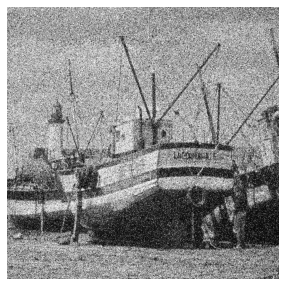

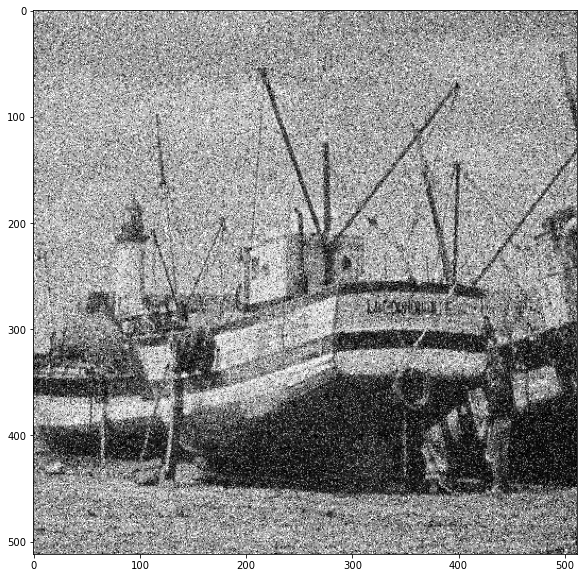

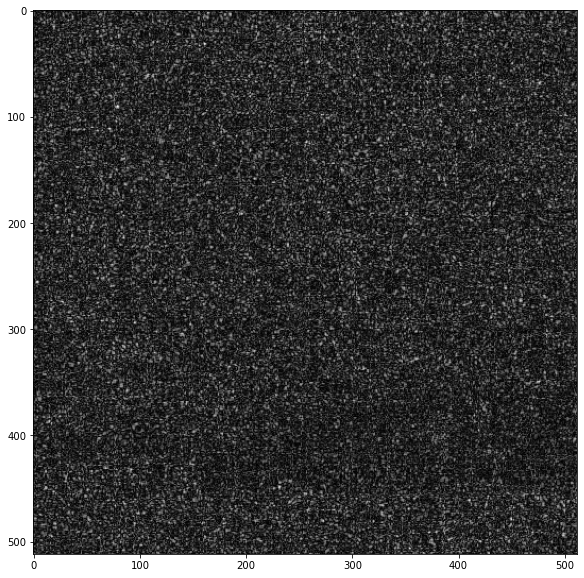

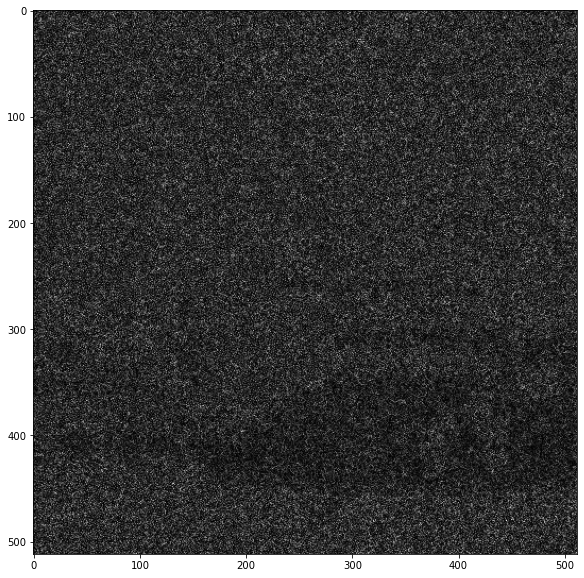

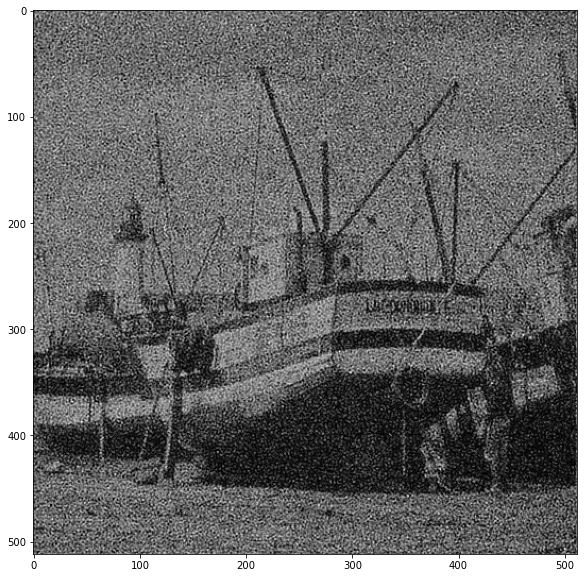

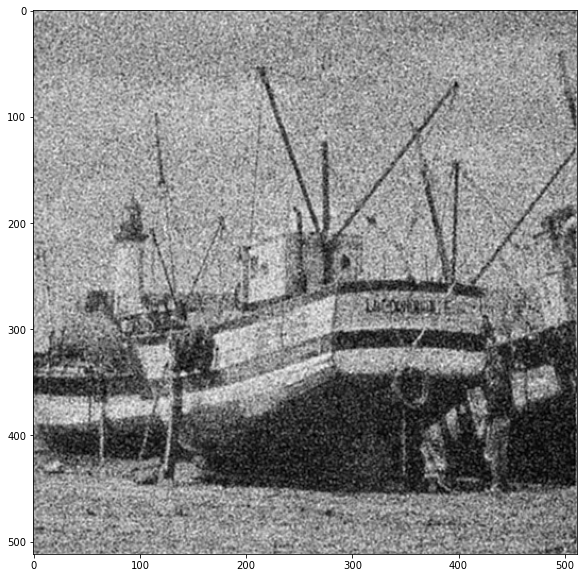

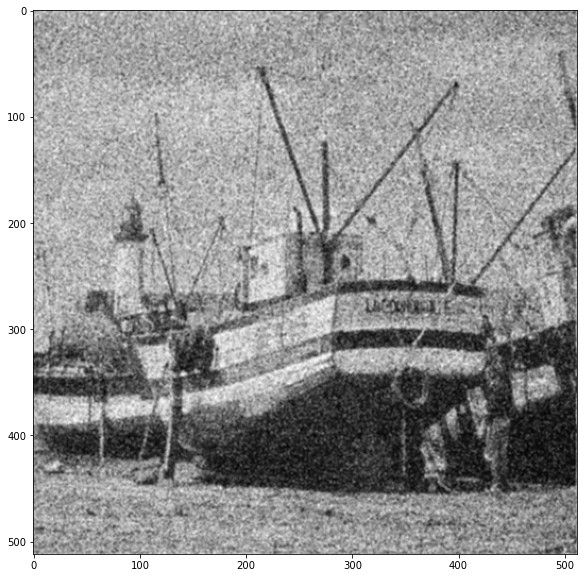

In [401]:
img = jjcv_rd.read_and_draw(fname, mode)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap="gray")

FT_Tool = Github_Fourier_Transform()
kernel = FT_Tool.gaussian_kernel(3)
#test = FT_Tool.wiener_filter(img, kernel, K=200)
test = FT_Tool.wiener_filter_2(img, kernel, K=1e-5)
plt.figure(figsize=(10,10))
plt.imshow(test, cmap="gray")
plt.show()

test = FT_Tool.wiener_filter_2(img, kernel, K=1e-3)
plt.figure(figsize=(10,10))
plt.imshow(test, cmap="gray")
plt.show()

test = FT_Tool.wiener_filter_2(img, kernel, K=1e-1)
plt.figure(figsize=(10,10))
plt.imshow(test, cmap="gray")
plt.show()

test = FT_Tool.wiener_filter_2(img, kernel, K=1e-0)
plt.figure(figsize=(10,10))
plt.imshow(test, cmap="gray")
plt.show()

test = FT_Tool.wiener_filter_2(img, kernel, K=1e1)
plt.figure(figsize=(10,10))
plt.imshow(test, cmap="gray")
plt.show()

In [433]:
h = gaussian(3, 0.7).reshape(3, 1)
h = np.dot(h, h.transpose())
h /= np.sum(h)

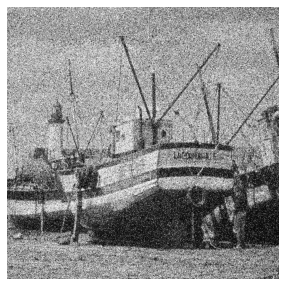

In [434]:
img = jjcv_rd.read_and_draw(fname, mode)

#kernel = FT_Tool.gaussian_kernel(3)
kernel = h
kernel_final = np.zeros(img.shape)
h, w = kernel.shape
kernel_final[:h,:w] = kernel
kernel_final /= np.sum(kernel_final)
kernel_FFT = FT_Tool.FFT_2D(kernel_final)
img_FFT = FT_Tool.FFT_2D(img)

In [435]:
ans = img_FFT/kernel_FFT

In [436]:
out = FT_Tool.inverseFFT_2D(ans)

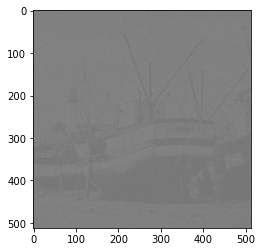

In [437]:
plt.imshow(out, cmap="gray")

In [322]:
# Make Gaussian Filters

class JJCV_Filters():

    def __init__(self):
        pass

    def distance(self, point1, point2):
        # functions ref: https://github.com/raoofnaushad
        return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

    def gaussianLP(self, D0, imgShape):
        # functions ref: https://github.com/raoofnaushad
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                base[y,x] = np.exp((-self.distance((y,x), center)**2)/(2*(D0**2)))
        return base

    def butterworthLP(self, D0, n, imgShape):
        
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                base[y,x] = 1/(1+(self.distance((y,x), center)/D0)**(2*n))
        return base

    def butterworthHP(self, D0, n, imgShape):
        
        base_LP = self.butterworthLP(D0, n, imgShape)
        
        return 1- base_LP
    
    def gaussianHP(self, D0, imgShape):
        # functions ref: https://github.com/raoofnaushad
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                base[y,x] = 1 - np.exp((-self.distance((y,x), center)**2)/(2*(D0**2)))
        return base
    
    def perfectLP(self, D0, imgShape):
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x), center) <= D0):
                    base[y, x] = 1
        return base

    def perfectHP(self, D0, imgShape):
        base = np.ones(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x), center) <= D0):
                    base[y, x] = 0
        return base
    
    def perfectLP_TopLeft(self, D0, imgShape):
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x), (0,0)) <= D0):
                    base[y, x] = 1
        return base

    def perfectHP_TopLeft(self, D0, imgShape):
        base = np.ones(imgShape[:2])
        rows, cols = imgShape[:2]
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x), (0,0)) <= D0):
                    base[y, x] = 0
        return base    
    

    def ringPass(self,inner_radius, outer_radius, imgShape):
        base = np.zeros(imgShape[:2])
        rows, cols = imgShape[:2]
        center = (rows/2, cols/2)
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x), center) <= outer_radius):
                    base[y, x] = 1
        for x in range(cols):
            for y in range(rows):
                if (self.distance((y,x),center)<= inner_radius):
                    base[y, x] = 0
        return base 
    
    # Borrow from HW2
    def LaplacianFilter(self, img, kernel_size):
        if kernel_size == 3:
            laplacian_filter = np.array([
                [ 0, -1,   0],
                [-1,  4, -1],
                [ 0, -1,   0],
            ])
            
        elif kernel_size == 5:
            laplacian_filter = np.array([
                [0,  0,    1, 0, 0],
                [0,  1,    2, 1, 0],
                [1, 2, -16, 2, 1],
                [0, 1,     2, 1, 0],
                [0, 0,     1, 0, 0]
            ])
            pass
        elif kernel_size ==7:
            laplacian_filter = np.array([
                [0, 0,  1,     1,   1, 0, 0],
                [0, 1,  3,     3,   3, 1, 0],
                [1, 3,  0,    -7,   0, 3, 1],
                [1, 3, -7, -24, -7, 3, 1],
                [1, 3,  0,    -7,   0, 3, 1],
                [0, 1,  3,      3,   3, 1, 0],
                [0, 0,  1,      1,    1, 0, 0],
            ])
        else:
            print("Kernel size should be one of [3, 5, 7].")
            
        im_filtered = np.zeros(img.shape, dtype=np.float32)
        im_filtered = self.convolution(img, laplacian_filter)
        im_filtered = np.maximum(im_filtered, np.zeros(im_filtered.shape))
        im_filtered = np.minimum(im_filtered, 255 * np.ones(im_filtered.shape))
        return im_filtered.astype(np.uint8)
    
    # Borrow from HW2
    def convolution(self, img, kernel):
        img_h = img.shape[0]
        img_w = img.shape[1]

        # Usually, kernel is square, but here we still use two varible to keep their dimensions
        kernel_h = kernel.shape[0]
        kernel_w = kernel.shape[1]
        kernel_flatten = self.flatten(kernel)

        # We need to pad the image, or after convolution, the img will become smaller
        pad_h = kernel_h // 2
        pad_w = kernel_w // 2
        pad_img = np.zeros((img_h+pad_h*2, img_w+pad_w*2))
        pad_img[pad_h:-pad_h, pad_w:-pad_w] = ref_img

        # Convolution
        trans_img = np.zeros(img.shape)
        for i in range(pad_h, img_h-pad_h):
            for j in range(pad_w, img_w-pad_w):
                x = pad_img[i-pad_h: i-pad_h+kernel_h, j-pad_w:j-pad_w+kernel_w]
                s = self.flatten(x) * kernel_flatten
                trans_img[i][j] = s.sum()

        return trans_img.astype(int)
    
    # Borrow from HW2
    def flatten(self, m):
        m = np.array(m)
        flatten_m = list()
        for i in range(m.shape[0]):
            for j in range(m.shape[1]):
                flatten_m.append(m[i][j])
        return np.array(flatten_m)
    


In [228]:
import random

class JJCV_Noise():
    
    def __init__(self):
        pass

    def Uniform_Noise(self, lower_bound, upper_bound):

        noise_list = []
        for i in range(512*512):
            lower_bound = -2
            upper_bound = +2
            noise_signal = lower_bound + random.random() * (upper_bound - lower_bound)
            noise_list.append(noise_signal)

        noise_array = np.array(noise_list).reshape(512,512)

        return noise_array


    def Gaussian_Noise(self, mean, sigma):
        gaussian = np.random.normal(mean, sigma, (512, 512)) 
        return gaussian


In [4]:
# import required packages

import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Read Image

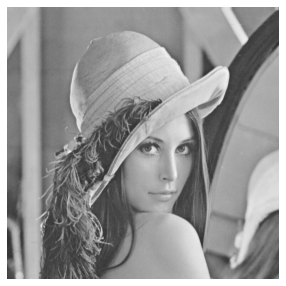

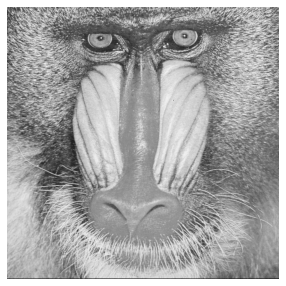

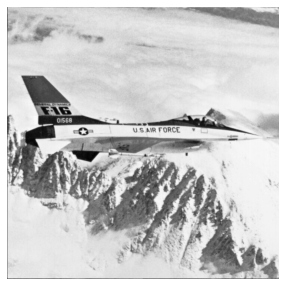

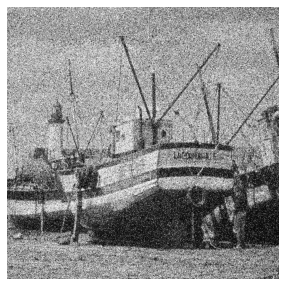

In [5]:
jjcv_rd = JJCV_Read_Draw(cmap="gray")
BASE_DIR = "../Data/Hw3/data/"
FILENAME_LIST = ["lena.raw", "baboon.raw", "F16.raw",  "Noisy.raw"]

for fname in FILENAME_LIST:
    fname = f"{BASE_DIR}{fname}"
    mode = fname[-3:]
    jjcv_rd.read_and_draw(fname, mode)

# (For Testing) Apply FFT from Numpy Package

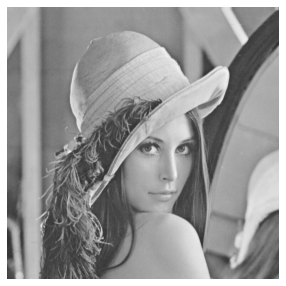

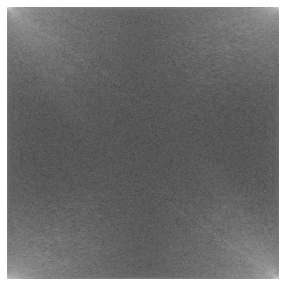

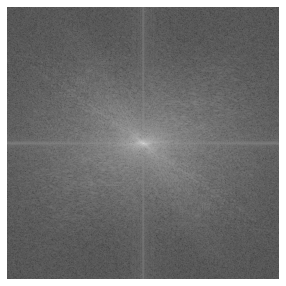

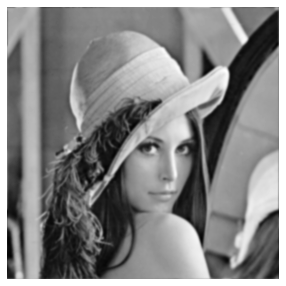

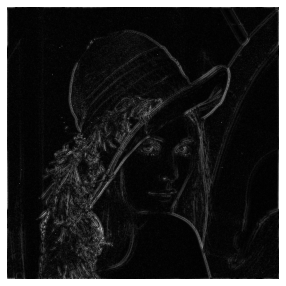

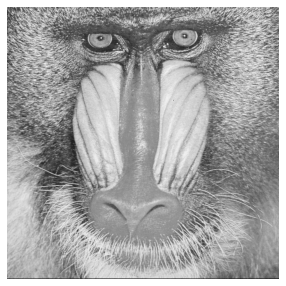

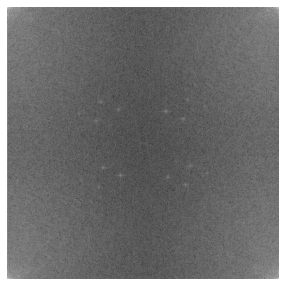

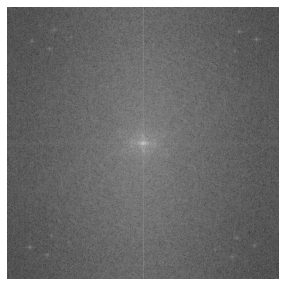

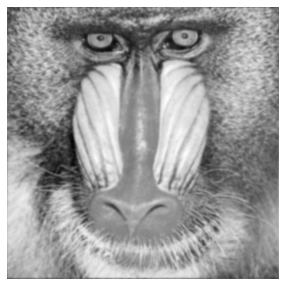

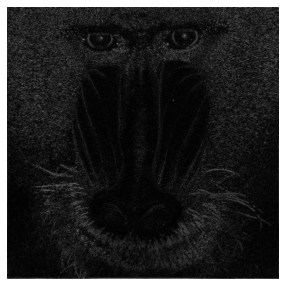

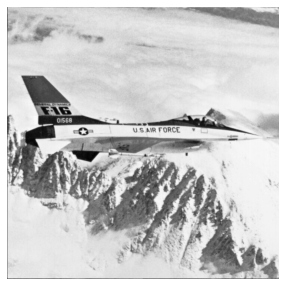

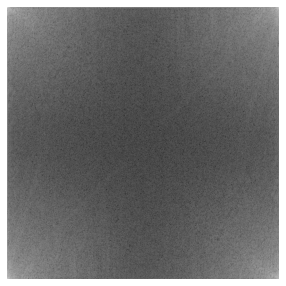

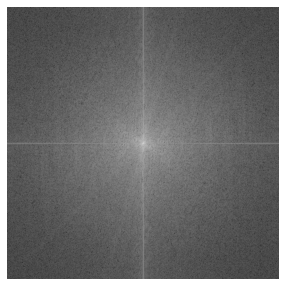

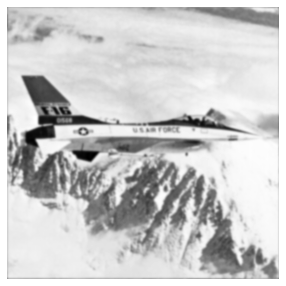

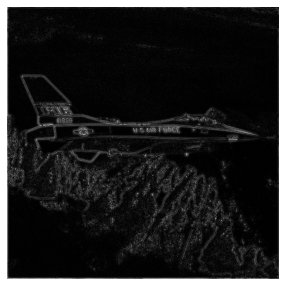

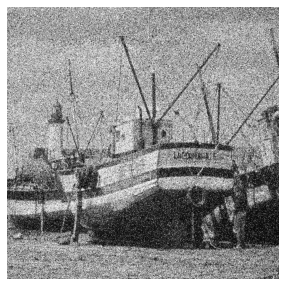

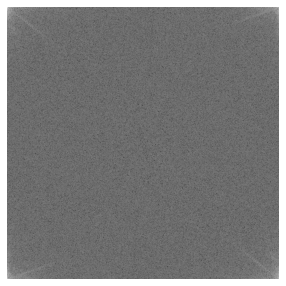

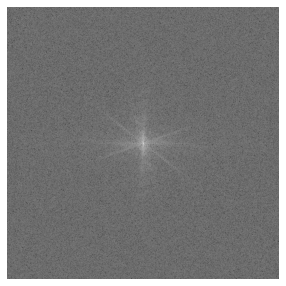

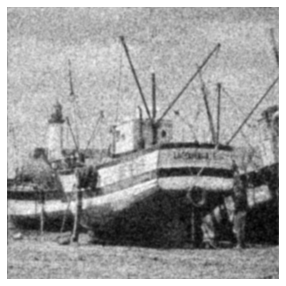

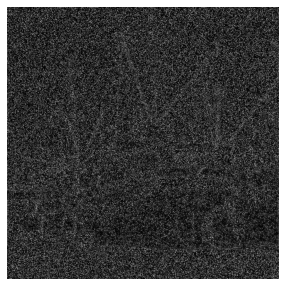

In [9]:
for fname in FILENAME_LIST:
    # Read Image
    fname = f"{BASE_DIR}{fname}"
    mode = fname[-3:]
    img = jjcv_rd.read_and_draw(fname, mode)
    
    # FFT Transform
    original = np.fft.fft2(img)
    plt.figure(figsize=(5,5))
    plt.imshow(np.log(1+np.abs(original)), cmap="gray")
    plt.axis("off")
    plt.show()
    
    # Shift
    center = np.fft.fftshift(original)
    plt.figure(figsize=(5,5))
    plt.imshow(np.log(1+np.abs(center)), cmap="gray")
    plt.axis("off")
    plt.show()
    
    # Filter in frequency domain
    LowPassCenter = center * gaussianLP(50, img.shape)
    LowPass = np.fft.ifftshift(LowPassCenter)
    inverse_LowPass = np.fft.ifft2(LowPass)
    plt.figure(figsize=(5,5))
    plt.imshow(np.abs(inverse_LowPass), cmap="gray")
    plt.axis("off")
    plt.show()
    
    # Reverse Back
    HighPassCenter = center * gaussianHP(50, img.shape)
    HighPass = np.fft.ifftshift(HighPassCenter)
    inverse_HighPass = np.fft.ifft2(HighPass)
    plt.figure(figsize=(5,5))
    plt.imshow(np.abs(inverse_HighPass), cmap="gray")
    plt.axis("off")
    plt.show()

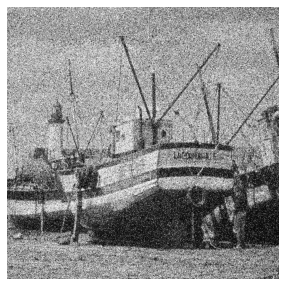

In [94]:
img = jjcv_rd.read_and_draw(fname, mode)

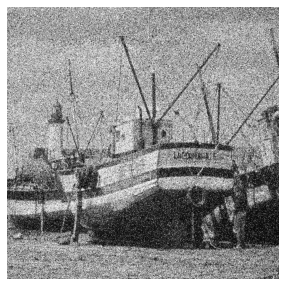

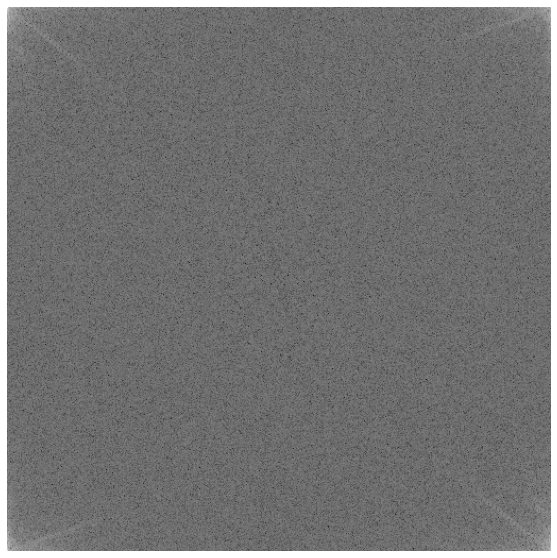

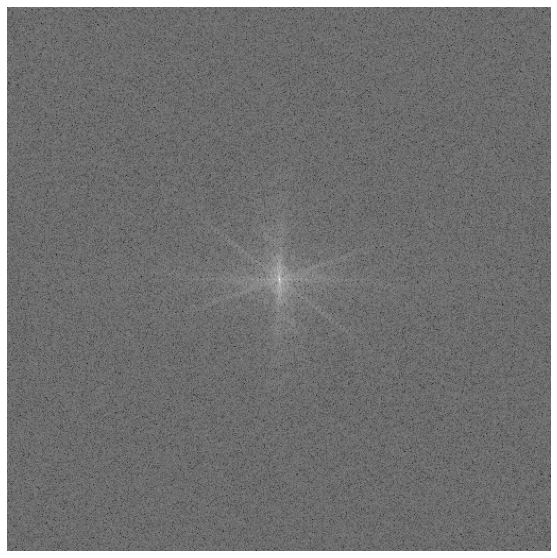

In [157]:
FT_Tool = Github_Fourier_Transform()
Filter_Tool = JJCV_Filters()

# Step 1: Read Image
img = jjcv_rd.read_and_draw(fname, mode)

# Step 2: Perform FFT
fft_img = FT_Tool.FFT_2D(img)

# Step 3: Center the FFT Image
centered_fft_img = FT_Tool.fftshift(fft_img)

# Step 4: Apply Filter on Centered FFT Image

# Step 5: Flip FFT Image Back to 4 Corners

# Step 6: Perform Inverse FFT

# Optional Step 1: Draw FFT Image
FT_Tool.plot_fft_img(fft_img)

# Optional Step 2: Draw Centered FFT Image
FT_Tool.plot_fft_img(centered_fft_img)

# Optional Step 3: Analyze Centered FFT Image


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:34<00:00,  1.19it/s]


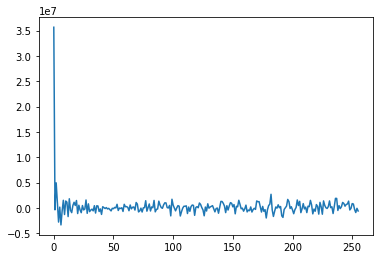

In [165]:
from tqdm import tqdm

real_list = []
for i in tqdm(range(256)):
    
    Ring = Filter_Tool.ringPass( i-1, i, (512, 512))
    Result = Ring * centered_fft_img
    real_list.append(sum(sum(np.real(Result))))
    
plt.plot(real_list)

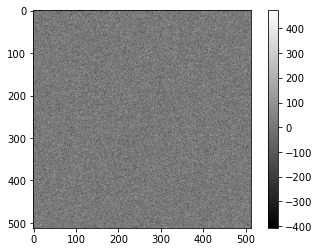

In [227]:
plt.imshow(Gaussian_Noise(10,100), cmap="gray")
plt.colorbar()
plt.show()

In [111]:
LowPassCenter = centered_fft_img * gaussianLP(10, centered_fft_img.shape)
cornerd_fft_img = fftshift(LowPassCenter)
ifft_img = inverseFFT_2D(cornerd_fft_img)
plt.imshow(ifft_img,cmap="gray")
plt.title("Transformed Image")
plt.show()

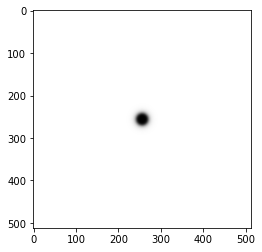

In [241]:
Filter_Tool = JJCV_Filters()

plt.imshow(Filter_Tool.butterworthHP(15, 3, (512,512)), cmap="gray")
plt.show()

In [242]:

import sys
from math import cos,sqrt,pi
import numpy as n_
import pylab as p_
import matplotlib.cm as cm

In [269]:
from math import cos, pi, sqrt
import numpy as np


def dct_2d(image, numberCoefficients=0):
    # REF https://github.com/AbraaoHonorio/DCT-Discrete-Cosine-Transform
    nc = numberCoefficients # passando para NC para melhorar a visibilidade da formula
    height = image.shape[0]
    width = image.shape[1]
    imageRow = np.zeros_like(image).astype(float)
    imageCol = np.zeros_like(image).astype(float)

    for h in tqdm(range(height)):
        imageRow[h, :] = dct_1d(image[h, :], nc) # aplicando IDCT na linhas
    for w in tqdm(range(width)):
        imageCol[:, w] = dct_1d(imageRow[:, w], nc) # aplicando IDCT nas colunas

    return imageCol

def dct_1d(image, numberCoefficients=0):
    # REF: https://github.com/AbraaoHonorio/DCT-Discrete-Cosine-Transform
    nc = numberCoefficients
    n = len(image)
    newImage= np.zeros_like(image).astype(float)

  
    for k in range(n):
        sum = 0
        for i in range(n):
            sum += image[i] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))
        ck = sqrt(0.5) if k == 0 else 1
        newImage[k] = sqrt(2.0 / n) * ck * sum

    # salvando os N maiores numeros e zerandos todos os outros
    if nc > 0:
        newImage.sort()
        for i in range(nc, n):
            newImage[i] = 0

    return newImage # retorno de um VETOR


def idct_2d(image):
    # REF: https://github.com/AbraaoHonorio/DCT-Discrete-Cosine-Transform
    height = image.shape[0]
    width =  image.shape[1]
    imageRow = np.zeros_like(image).astype(float)
    imageCol = np.zeros_like(image).astype(float)

  
    for h in tqdm(range(height)):
        imageRow[h, :] = idct_1d(image[h, :]) # aplicando IDCT na linhas
    for w in tqdm(range(width)):
        imageCol[:, w] = idct_1d(imageRow[:, w]) # aplicando IDCT nas colunas

    return imageCol

def idct_1d(image):
   
    n = len(image)
    newImage = np.zeros_like(image).astype(float)

    for i in range(n):
        sum = 0
        for k in range(n):
            ck = sqrt(0.5) if k == 0 else 1 # operador tenario para verificar o valor do CK
            sum += ck * image[k] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))

        newImage[i] = sqrt(2.0 / n) * sum

    return newImage

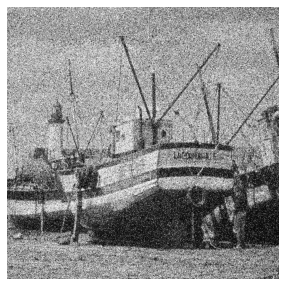

In [321]:
img = jjcv_rd.read_and_draw(fname, mode)


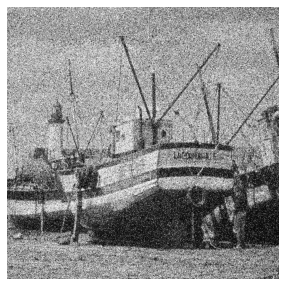

In [320]:
img = jjcv_rd.read_and_draw(fname, mode)

In [279]:
dct_img = dct_2d(img)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [01:17<00:00,  6.61it/s]


In [282]:
dct_img.shape

(512, 512)

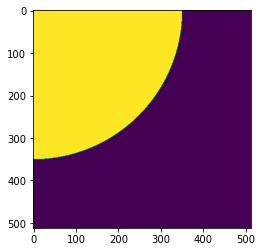

In [314]:
Filter_Tool = JJCV_Filters()

mask = Filter_Tool.perfectLP_TopLeft(350, (512,512))

test = mask * dct_img
FT_Tool.plot_fft_img(test)
back = idct_2d(test)


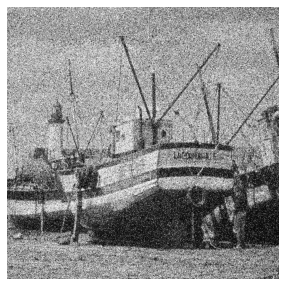

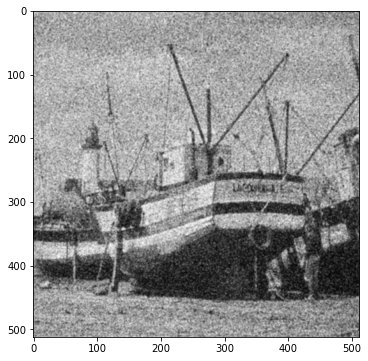